In [1]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color

# Question 1: Band-Pass Filter (20 points)
The goal of this problem is to implement a band-pass filter using two Gaussian filters. The DoG filter (The Difference of Gaussian) is defined as the difference of two Gaussian kernels with different variances 𝜎1 and 𝜎2. For simplicity, let 𝜎2 = 𝑘 𝜎1 for some k and subtract the Gaussian kernel with variance 𝜎1 from the kernel with 𝜎2. (Helpful functions: getGaussianKernel, plot_surface, copyMakeBorder, filter2D)

a) (10 points) You need to write a 2d-DoG function, “myDoG(DoGsize, sigma1, k)”. This function produces a kernel of size DoGsize that is the difference of two gaussian kernels with corresponding variances 𝜎1 and 𝜎2 = 𝑘 𝜎1.

In [2]:
def myDoG(DoGsize, sigma1, k):
    sigma2 = k * sigma1
    square_size = min(DoGsize)
    kernel1 = cv2.getGaussianKernel(square_size, sigma1)
    kernel1 = kernel1 * np.transpose(kernel1)
    kernel2 = cv2.getGaussianKernel(square_size, sigma2)
    kernel2 = kernel2 * np.transpose(kernel2)
    kernel = kernel2 - kernel1
    rows_border = max(0, int((DoGsize[0] - square_size) / 2))
    cols_border = max(0, int((DoGsize[1] - square_size) / 2))
    return cv2.copyMakeBorder(kernel, rows_border, rows_border, cols_border, cols_border, cv2.BORDER_CONSTANT, None, value=0)

b) (5 points) Use this function to generate four 2d-DoG filters with 𝜎1 = 1, 2, 3, 4, k = 1.5, and a window size ten times 𝜎1. Show the 3d illustration of the four 2d-DoG filters in a 2x2 grid with appropriate labels.

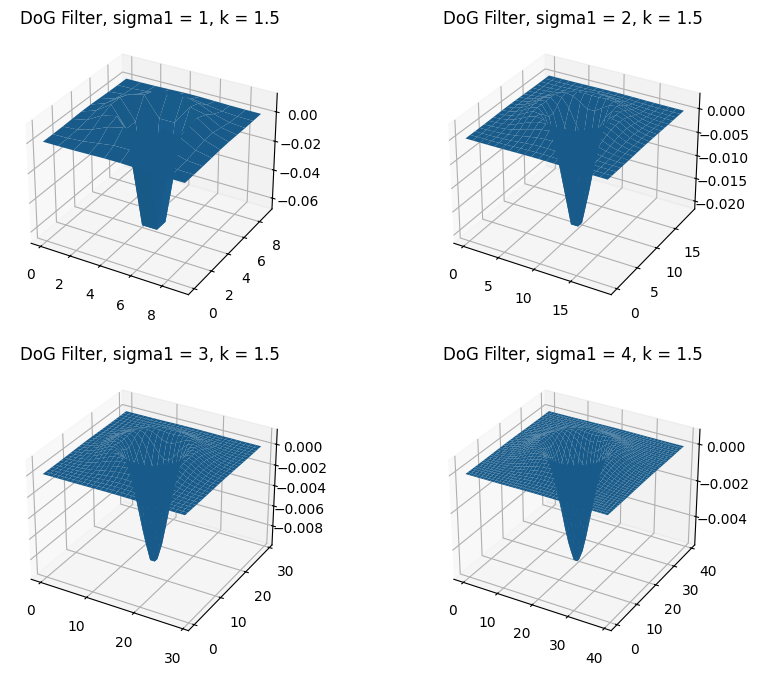

In [3]:
filters = [myDoG((sigma1 * 10, sigma1 * 10), sigma1, 1.5) for sigma1 in range(1, 5)]
ranges = [range(sigma1 * 10) for sigma1 in range(1, 5)]

fig = plt.figure(figsize=(10, 8))
for i in range(len(filters)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    X, Y = np.meshgrid(ranges[i], ranges[i])
    ax.title.set_text('DoG Filter, sigma1 = ' + str(i+1) + ', k = 1.5')
    ax.plot_surface(X, Y, filters[i])

plt.show()

c) (5 points) Read in cars.jpg and convert it to gray-scale. Generate the same four 2d-DoG filters as in part b. Apply the filters to cars.jpg using a method of your choosing (recall the methods used in HW2). Display the filtered images in a 2x2 grid with the appropriate labels. Write a few lines on what you observe, and why.

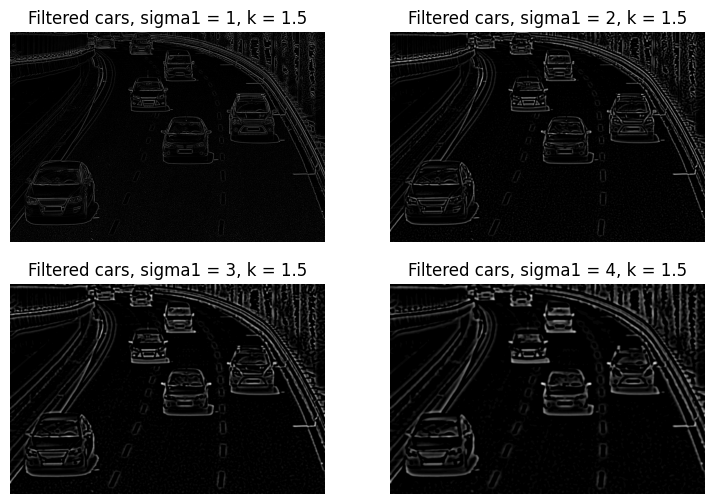

In [4]:
cars = mpimg.imread('images/cars.jpg')
g_cars = (color.rgb2gray(cars) * 255).astype(np.uint8)

filtered_imgs = [cv2.filter2D(src=g_cars, ddepth=-1, kernel=filters[i]) for i in range(len(filters))]

fig = plt.figure(figsize=(9, 6))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.axis('off')
    ax.title.set_text('Filtered cars, sigma1 = ' + str(i+1) + ', k = 1.5')
    ax.imshow(np.real(filtered_imgs[i]), cmap='gray')
plt.show()

# Question 2 : Non Local (NL) Means (40 points)
Here we will be looking at the application of Non-Local Means in removing noise. Helpful functions: skimage.util.view_as_windows, scipy.spatial.distance.cdist, padarray, im2col, pdist2, sum, reshape.

a) (5 points) You need to read bird.jpg, convert it to grayscale, and resize the image so that it is a perfect square. Display this resulting image.

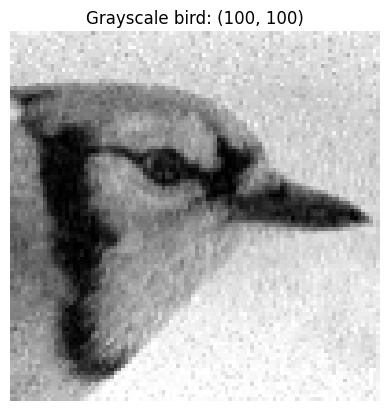

In [5]:
bird = mpimg.imread('images/bird.jpg')
g_bird = color.rgb2gray(bird)
size = max(g_bird.shape)
g_bird = cv2.resize(g_bird, (size, size))

imgplot = plt.imshow(g_bird, cmap='gray', vmin=0, vmax=1)
plt.title('Grayscale bird: ' + str(g_bird.shape))
plt.axis('off')
plt.show()

b) (15 points) You will now calculate the Luminance Similarity Measure “W(m,i)” between all the 3x3 square windows in the image, using the information given in Module 5 slide 14 onwards. Use Kw = 1 and 𝜎w = 1. Normalize “W(m, i)” so that the sum across each row is equal to 1.0. Note that even though this is a small image, this step will likely take a while to execute (a few minutes depending on hardware).

In [8]:
# Finds the luminance similarity between two input windows, M and I
def similarity(Kw, sigmaw, M, I):
    return Kw * np.exp(-np.sum(np.square(I - M)) / (sigmaw ** 2))

window_size = 3
padding = window_size // 2
padded = np.pad(array=g_bird, pad_width=padding, mode='edge')
windows = np.lib.stride_tricks.sliding_window_view(padded, (window_size, window_size))
windows = windows.reshape((windows.shape[0] * windows.shape[1], windows.shape[2], windows.shape[3]))
W = np.zeros((windows.shape[0], windows.shape[0]))
# Note: you can speed this computation up a lot by not using for loops here
for m in range(W.shape[0]):
    for i in range(W.shape[1]):
        W[m, i] = similarity(Kw=1, sigmaw=1, M=windows[m], I=windows[i])

for m in range(W.shape[0]):
    sum = np.sum(W[m])
    if sum != 0:
        W[m, :] /= sum

c) (5 points) From all the windows, we will now compare the similarity measure images generated between choosing two different windows in the image. For this part, take the 3x3 window in the top-left corner of the image, and reshape it to a 3x3 matrix. Take the first row in W which corresponds to all of the pair-wise distances to that 3x3 window, and reshape it to the size of the image. Display the resulting window and image side by side with appropriate labels.

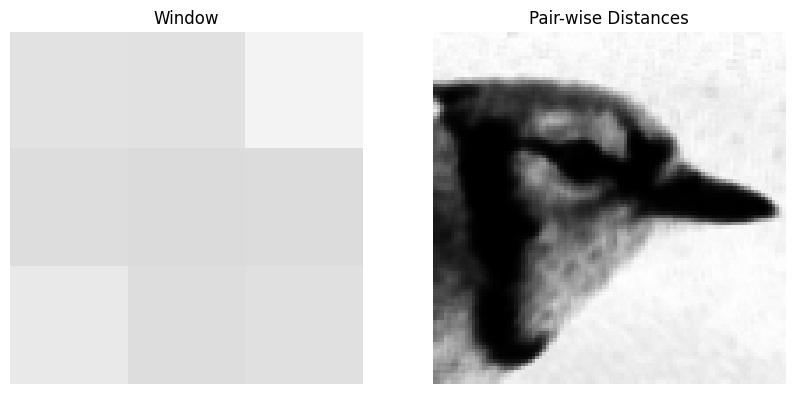

In [9]:
window = windows[g_bird.shape[0] + 1]
similarities = W[g_bird.shape[0] + 1].reshape(g_bird.shape)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Window')
ax2.title.set_text('Pair-wise Distances')
ax1.imshow(window, cmap='gray', vmin=0, vmax=1)
ax2.imshow(similarities, cmap='gray')
plt.show()

d) (5 points) You will now need to repeat the same operation you did in part c), but by taking the 3x3 window in the middle of the left side of the image. Display the resulting window and the original image side by side with appropriate labels.

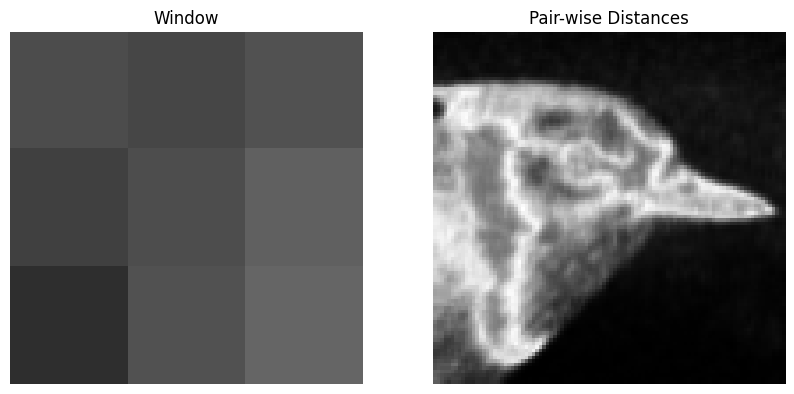

In [10]:
window = windows[(g_bird.shape[0] // 2) * g_bird.shape[0] + (g_bird.shape[1] // 4)]
similarities = W[(g_bird.shape[0] // 2) * g_bird.shape[0] + (g_bird.shape[1] // 4)].reshape(g_bird.shape)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Window')
ax2.title.set_text('Pair-wise Distances')
ax1.imshow(window, cmap='gray', vmin=0, vmax=1)
ax2.imshow(similarities, cmap='gray')
plt.show()

f) (10 points) Using the luminance similarity measure, perform Non Local (NL) Means
filtering on bird.jpg, and remove the noise. Display the resulting image and the original
image in a 2x1 grid with appropriate results. Comment a few lines on the result achieved.

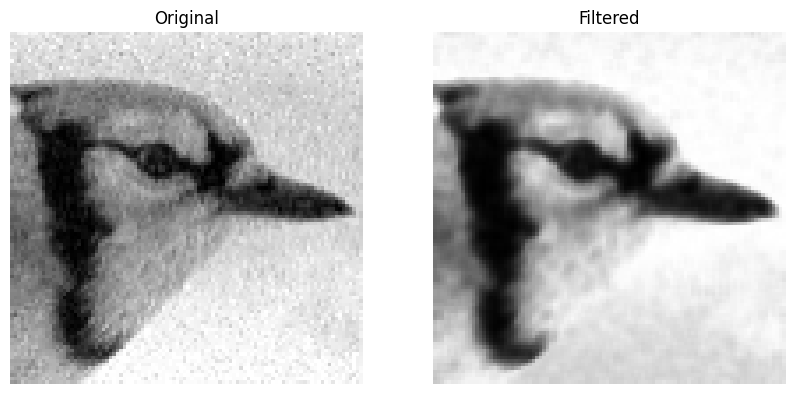

In [11]:
flattened = g_bird.flatten()
filtered = np.zeros(flattened.shape)

for i in range(flattened.size):
    filtered[i] = np.dot(W[:, i], flattened)

filtered = filtered.reshape(g_bird.shape)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.axis('off')
ax2.axis('off')
ax1.title.set_text('Original')
ax2.title.set_text('Filtered')
ax1.imshow(g_bird, cmap='gray')
ax2.imshow(filtered, cmap='gray')
plt.show()

# Question 3: Block Truncation Coding (BTC) (25 points)
BTC is a fast and lossy compression technique. In this problem, we will understand how BTC is used, along with its advantages and disadvantages. 4x4 blocks are used where applicable in the following sub-problems. You can use the following link to learn more about BTC: https://en.wikipedia.org/wiki/Block_Truncation_Coding#Encoder . Helpful functions: col2im, im2col, bi2de, de2bi.

a) (5 points) You should read bevo.jpg, and make it grayscale. Resize the image by a factor of ½ to make the compression faster. Resize the image further such that the height and width of the images are both multiples of 4; such that it is still roughly the same dimensions as ½ of the original image dimensions. Display the grayscale compressed image.

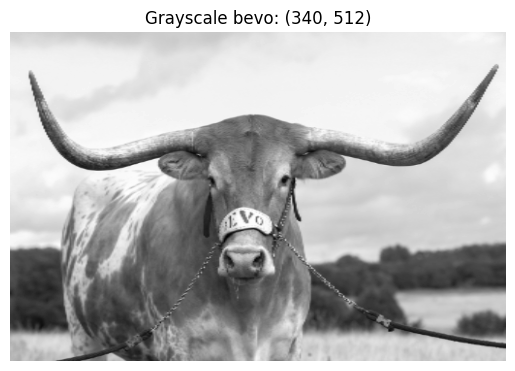

In [12]:
bevo = mpimg.imread('images/bevo.jpg')
g_bevo = 255 * color.rgb2gray(bevo)
g_bevo = cv2.resize(g_bevo, (g_bevo.shape[0] // 2, g_bevo.shape[1] // 2))
rows = (g_bevo.shape[0] // 4) * 4
cols = (g_bevo.shape[1] // 4) * 4
g_bevo = cv2.resize(g_bevo, (rows, cols))

imgplot = plt.imshow(g_bevo, cmap='gray')
plt.title('Grayscale bevo: ' + str(g_bevo.shape))
plt.axis('off')
plt.show()

b) (5 points) Write a function to compute the mean and standard deviation of a 4x4 block with ‘B1’ bits to compute and store the mean, and ‘B2’ bits to compute and store the standard deviation; where ‘B1’ and ‘B2’ are input parameters to the function. Hint: you might need to compute the mean and standard deviation values, and then truncate in the end based on ‘B1’ and ‘B2’ parameter values.

In [13]:
def analyze_block(block, B1, B2):
    mean = (np.mean(block) // (2 ** (8 - B1))) * (2 ** (8 - B1))
    stddev = (np.std(block) // (2 ** (8 - B2))) * (2 ** (8 - B2))
    return mean, stddev

c) (5 points) Write a function to compute the 4x4 BTC binary block by thresholding the input 4x4 image block at the mean. Pass bevo.jpg through this function for 3 different ‘B1’, ‘B2’ settings; {2,1}, {3,3}, and {7,5}. Compute the BTC binary blocks image for bevo.jpg, and display the 3 images in a 3x1 grid with appropriate labels.

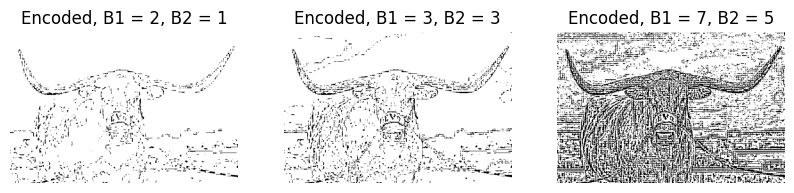

In [14]:
def encode_btc_block(block, mean):
    coded_block = block.copy()
    coded_block[coded_block < mean] = 0
    coded_block[coded_block >= mean] = 1
    return coded_block

def encode_btc_image(img, B1, B2):
    coded = np.zeros(img.shape)
    rows, cols = img.shape
    means = np.zeros((rows // 4, cols // 4))
    stddevs = np.zeros(means.shape)
    for i in range(rows // 4):
        for j in range(cols // 4):
            block = img[i*4:(i+1)*4, j*4:(j+1)*4]
            means[i, j], stddevs[i, j] = analyze_block(block, B1, B2)
            coded[i*4:(i+1)*4, j*4:(j+1)*4] = encode_btc_block(block, means[i, j])
    return coded, means, stddevs

btc_imgs = []
btc_imgs.append(encode_btc_image(g_bevo, 2, 1))
btc_imgs.append(encode_btc_image(g_bevo, 3, 3))
btc_imgs.append(encode_btc_image(g_bevo, 7, 5))

fig = plt.figure(figsize=(10, 2))
ax = []
for i in range(3):
    ax.append(fig.add_subplot(1,3,i+1))
    ax[i].axis('off')
ax[0].title.set_text('Encoded, B1 = 2, B2 = 1')
ax[1].title.set_text('Encoded, B1 = 3, B2 = 3')
ax[2].title.set_text('Encoded, B1 = 7, B2 = 5')
ax[0].imshow(btc_imgs[0][0], cmap='gray')
ax[1].imshow(btc_imgs[1][0], cmap='gray')
ax[2].imshow(btc_imgs[2][0], cmap='gray')
plt.show()

d) (5 points) Write a function to decode a 4x4 BTC binary block given the mean and standard deviation as the input parameters, and get back the original 4x4 image block. Pass the 3 BTC binary block images generated in part c) through this function, for the aforementioned ‘B1’, ‘B2’ settings; and get back the 3 decompressed bevo.jpg images. Display these three images along with the original image in a 2x2 grid with appropriate labels.

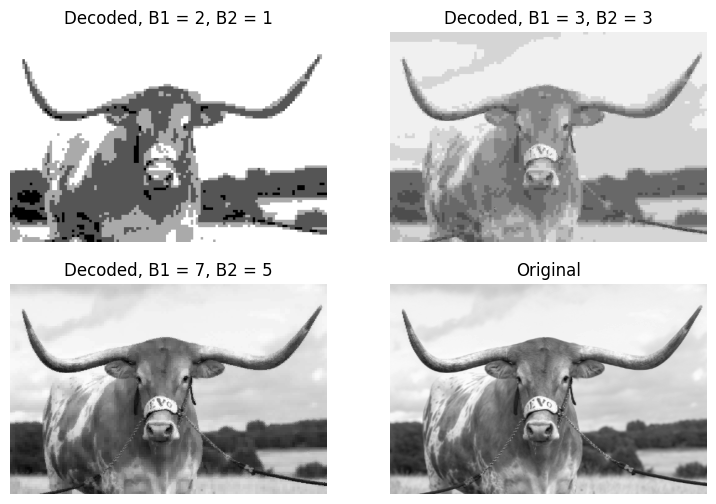

In [15]:
def decode_btc_block(block, mean, stddev):
    Q = np.count_nonzero(block)
    P = 16 - Q
    decoded_block = block.copy()
    for i in range(block.shape[0]):
        for j in range(block.shape[1]):
            decoded_block[i, j] = mean + stddev * math.sqrt(P / Q) if block[i, j] == 1 else mean - stddev * math.sqrt(Q / P)
    return decoded_block

def decode_btc_image(img, means, stddevs):
    decoded = np.zeros(img.shape)
    rows, cols = img.shape
    for i in range(rows // 4):
        for j in range(cols // 4):
            block = img[i*4:(i+1)*4, j*4:(j+1)*4]
            decoded[i*4:(i+1)*4, j*4:(j+1)*4] = decode_btc_block(block, means[i, j], stddevs[i, j])
    return decoded

fig = plt.figure(figsize=(9, 6))
ax = []
for i in range(4):
    ax.append(fig.add_subplot(2,2,i+1))
    ax[i].imshow(decode_btc_image(*btc_imgs[i]) if i < 3 else g_bevo, cmap='gray')
    ax[i].axis('off')
ax[0].title.set_text('Decoded, B1 = 2, B2 = 1')
ax[1].title.set_text('Decoded, B1 = 3, B2 = 3')
ax[2].title.set_text('Decoded, B1 = 7, B2 = 5')
ax[3].title.set_text('Original')
plt.show()

e) (5 points) Compute and report the compression ratios for the 3 BTC encoded images generated.

In [16]:
original_bpp = 8
btc_1_bpp = (16 + 2 + 1) / 16
btc_2_bpp = (16 + 3 + 3) / 16
btc_3_bpp = (16 + 7 + 5) / 16

print(f'Compression Ratio for B1 = 2, B2 = 1 is {round(original_bpp / btc_1_bpp, 3)}:1')
print(f'Compression Ratio for B1 = 3, B2 = 3 is {round(original_bpp / btc_2_bpp, 3)}:1')
print(f'Compression Ratio for B1 = 7, B2 = 5 is {round(original_bpp / btc_3_bpp, 3)}:1')

Compression Ratio for B1 = 2, B2 = 1 is 6.737:1
Compression Ratio for B1 = 3, B2 = 3 is 5.818:1
Compression Ratio for B1 = 7, B2 = 5 is 4.571:1


# Question 4: VGG19 Feature Extraction (15 points)
VGG19 is a convolutional neural network architecture used primarily for image classification. The network is primarily composed of 3x3 convolutional filters, making it effective at capturing intricate and abstract features in images. In this problem we will utilize a pre-trained VGG19 network to extract features maps from an image. These features can be very useful for other applications; for example, you can compare two images by comparing their corresponding extracted feature maps instead of using their original representations which can help highlight perceptually relevant differences. For more on this see https://arxiv.org/pdf/1603.08155.pdf

a) (5 points) Download and load a pre-trained version of the VGG19 model. Most machine learning frameworks should have a way to download and use pre-trained networks directly. With PyTorch you can use: https://pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html

In [18]:
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

vgg19 = models.vgg19(pretrained=True)

(5 points) Read lion.jpg and transform it so that it is suitable for the model. The corresponding transform may depend on the pre-trained version of the model that you are using. For the default version in PyTorch, you will need to resize the image to 224x224 and normalize it to the ImageNet dataset mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. Display the transformed image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


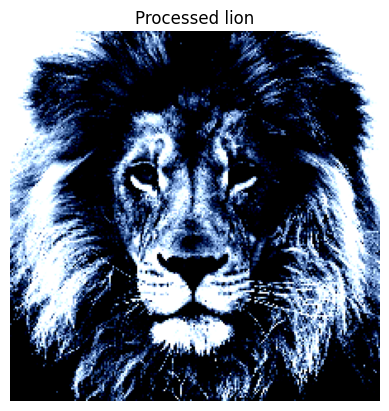

In [20]:
image_path = 'images/lion.jpg'
image = mpimg.imread(image_path)
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
imgplot = plt.imshow(np.transpose(preprocess(image), (1, 2, 0)))
plt.title('Processed lion')
plt.axis('off')
plt.show()

(5 points) Experiment with passing the transformed image through layers of the network. Note that you may need to add a dummy batch dimension to the input tensor for the model to accept it. Find three feature maps that look interesting to you and display them. In Pytorch you can get a list of vgg19’s layers by accessing its features field. Then you can use slicing to use only a subset of these layers and get the results of passing your input through them.

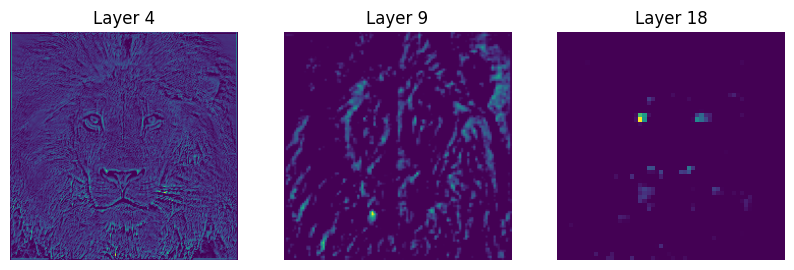

In [21]:
input_tensor = preprocess(image).unsqueeze(0)

# Using slicing to select three parts of the model, and running our input through each
layers_to_test = [vgg19.features[:4], vgg19.features[:9], vgg19.features[:18]]
output = [layers_to_test[i](input_tensor) for i in range(len(layers_to_test))]

# Each output is a set of feature maps. Here we display feature map #5 from layer output
fig = plt.figure(figsize=(10, 4))
ax = []
for i in range(3):
    ax.append(fig.add_subplot(1,3,i+1))
    ax[i].axis('off')
    ax[i].imshow(output[i].detach().numpy().squeeze()[5], cmap='viridis')
ax[0].title.set_text('Layer 4')
ax[1].title.set_text('Layer 9')
ax[2].title.set_text('Layer 18')
plt.show()

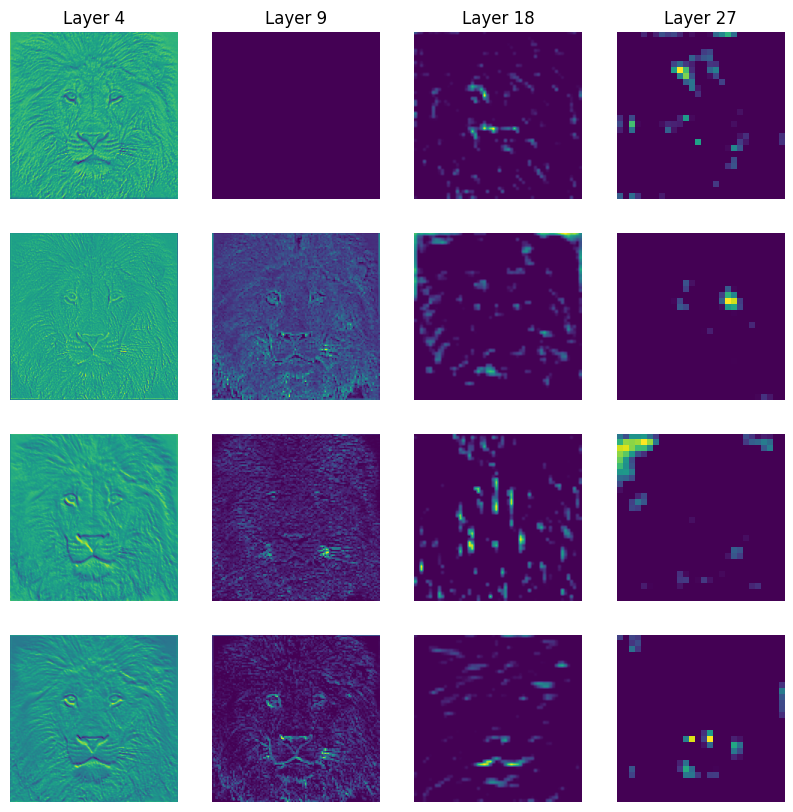

In [22]:
# Plotting some more examples
input_tensor = preprocess(image).unsqueeze(0)

# Using slicing to select three parts of the model, and running our input through each
layers_to_test = [vgg19.features[:3], vgg19.features[:5], vgg19.features[:18], vgg19.features[:27]]
output = [layers_to_test[i](input_tensor) for i in range(len(layers_to_test))]

# Each output is a set of feature maps. Here we display feature map #5 from layer output
fig = plt.figure(figsize=(10, 10))
ax = []
for i in range(16):
    ax.append(fig.add_subplot(4,4,i+1))
    ax[i].axis('off')
    ax[i].imshow(output[i % 4].detach().numpy().squeeze()[i], cmap='viridis')
ax[0].title.set_text('Layer 4')
ax[1].title.set_text('Layer 9')
ax[2].title.set_text('Layer 18')
ax[3].title.set_text('Layer 27')
plt.show()